In [1]:
import pandas as pd
import codecs
import numpy as np
import math
import csv
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import recall_score, precision_score # New
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import numpy as np

PV = 'C:/Users/Smartgrid_ML/Documents/KMS/btm_data/korean_data/pv/seobu_pv.csv'
pv_source = pd.read_csv(PV, encoding='CP949')
pv_source = pd.DataFrame(pv_source)
pv_source = pv_source.iloc[0:1277, :]
pv_data = np.array(pv_source)

weather_17 = 'C:/Users/Smartgrid_ML/Documents/KMS/btm_data/korean_data/pv/mokpo_2017.csv'
weather_18 = 'C:/Users/Smartgrid_ML/Documents/KMS/btm_data/korean_data/pv/mokpo_2018.csv'
weather_19 = 'C:/Users/Smartgrid_ML/Documents/KMS/btm_data/korean_data/pv/mokpo_2019.csv'
weather_20 = 'C:/Users/Smartgrid_ML/Documents/KMS/btm_data/korean_data/pv/mokpo_2020.csv'

weather_17 = pd.read_csv(weather_17, encoding='CP949')
weather_18 = pd.read_csv(weather_18, encoding='CP949')
weather_19 = pd.read_csv(weather_19, encoding='CP949')
weather_20 = pd.read_csv(weather_20, encoding='CP949')
weather = pd.concat([weather_17,weather_18,weather_19,weather_20])
weather_data = np.array(weather)

pv_data = np.nan_to_num(pv_data)
weather_data = np.nan_to_num(weather_data)
pv_dat = pv_data[:, 2:]
weather_dat = weather_data[:, 3:]
pv_dat = pv_dat.reshape(-1,1)

dataset = np.hstack([pv_dat, weather_dat])
index = ['Measured PV', 'Temperature C', 'Rainfall', 'Wind speed', 'Wind direction', 'Humidity', 'Air pressure', 'Dew point C', 'Sunshine', 'Solar radiation', 'Snowfall', 'Cloud cover', 'Surface temp C']

df = pd.DataFrame(dataset, columns=index)
df.head()
df = df.fillna(0)
min_max_scaler = preprocessing.MinMaxScaler()
norm_df = pd.DataFrame(min_max_scaler.fit_transform(df), 
                             columns=df.columns, 
                             index=df.index)
norm_df.head()

,Measured PV,Temperature C,Rainfall,Wind speed,Wind direction,Humidity,Air pressure,Dew point C,Sunshine,Solar radiation,Snowfall,Cloud cover,Surface temp C
0,0.0,0.354298,0.0,0.023256,0.000000,0.89,0.189696,0.444681,0.0,0.0,0.0,0.6,0.141834
1,0.0,0.339623,0.0,0.104651,0.444444,0.93,0.189696,0.442553,0.0,0.0,0.0,0.0,0.117479
2,0.0,0.320755,0.0,0.046512,0.388889,0.93,0.177986,0.423404,0.0,0.0,0.0,0.0,0.103152
3,0.0,0.303983,0.0,0.087209,0.444444,0.94,0.170960,0.410638,0.0,0.0,0.0,0.0,0.095989
4,0.0,0.287212,0.0,0.104651,0.444444,0.95,0.161593,0.395745,0.0,0.0,0.0,0.0,0.088825


In [2]:
norm_df = np.array(norm_df)
norm_df2 = norm_df[:,(0, 1, 4, 5, 6, 8, 9, 11, 12)]
print(norm_df2.shape)

(30648, 9)


In [3]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()

import tensorflow.keras.preprocessing
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Flatten, Add, Multiply
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation, BatchNormalization
# regularizers
from tensorflow.keras.layers import Conv1D, Conv2D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.layers import Dense, Input, Flatten, Add, concatenate, Dropout, Activation, Multiply
from tensorflow.keras.layers import LSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D  
from tensorflow.keras.layers import Conv1D, AveragePooling1D, MaxPooling1D
from tensorflow.keras.utils import plot_model
from tensorflow.keras import activations
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
def get_flops(model):
    run_meta = tf.RunMetadata()
    opts = tf.profiler.ProfileOptionBuilder.float_operation()

    # We use the Keras session graph in the call to the profiler.
    flops = tf.profiler.profile(graph=K.get_session().graph,
                                run_meta=run_meta, cmd='op', options=opts)

    return flops.total_float_ops  # Prints the "flops" of the model.

def create_dataset(dataset, timesteps, output_timesteps):
    dataX, dataY = [], []
    for i in range(len(dataset) - timesteps -output_timesteps - 1):
        a = dataset[i:(i + timesteps), :]
        dataX.append(a)
        dataY.append(dataset[(i + timesteps):(i+timesteps+output_timesteps), :])
    return np.array(dataX), np.array(dataY)

class LossHistory(tensorflow.keras.callbacks.Callback):  # history = LossHistory()
    def init(self):  # history.init()
        self.losses = []
        # self.accs = []
        self.val_losses = []
        # self.val_accs = []
        self.rmses = []
        self.mses = []
        self.maes = []
        self.mapes = []
        self.val_rmses = []
        self.val_mses = []
        self.val_maes = []
        self.val_mapes = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        # self.accs.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        # self.val_accs.append(logs.get('val_accuracy
        self.rmses.append(logs.get('root_mean_squared_error'))
        self.mses.append(logs.get('mean_squared_error'))
        self.maes.append(logs.get('mean_absolute_error'))
        self.mapes.append(logs.get('mean_absolute_percentage_error'))
        self.val_rmses.append(logs.get('val_root_mean_squared_error'))
        self.val_mses.append(logs.get('val_mean_squared_error'))
        self.val_maes.append(logs.get('val_mean_absolute_error'))
        self.val_mapes.append(logs.get('val_mean_absolute_percentage_error'))

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
timesteps = 24
output_timesteps = 12

X, Y = create_dataset(norm_df2, timesteps, output_timesteps)

trX = X[:18389, :, :]
vaX = X[18389:21453, :, :]
teX = X[21453:, :, :]
trY = Y[:18389, :, 0]
vaY = Y[18389:21453, :, 0]
teY = Y[21453:, :, 0]

print(trX.shape)
print(trY.shape)
print(teX.shape)

(18389, 24, 9)
(18389, 12)
(9158, 24, 9)


In [5]:
with tf.device('/gpu:0'):
    alpha=0.5
    beta = math.sqrt(2/alpha)
    num_features = 9
    hfilters = 256
    hkernel_size1 = 16
    hkernel_size2 = 32
    visible1 = Input(shape=(24, num_features))
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=1)(visible1)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=2)(d1)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res01 = Add()([d1, visible1])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=2)(res01)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=4)(d1)    
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res02 = Add()([d1, res01])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=4)(res02) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=8)(d1) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res03 = Add()([d1, res02])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=8)(res03)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=16)(d1)  
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res04 =Add()([d1, res03])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=16)(res04)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=32)(d1)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res05 = Add()([d1, res04])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=32)(res05) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=16)(d1)   
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res06 = Add()([d1, res05])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=16)(res06) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=8)(d1)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res07 = Add()([d1, res06])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=8)(res07)  
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=4)(d1) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res08 = Add()([d1, res07])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=4)(res08)   
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=2)(d1)  
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res09 = Add()([d1, res08])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=2)(res09) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=1)(d1)    
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res10 = Add()([d1, res09])   # (100, 25) (100, 25)
    out = Conv1D(512, 1, padding='same', activation='relu')(res10)   # --------------------  
    out = Dropout(0.2)(out)   
    out = Conv1D(256, 1, padding='same', activation='relu')(out) # 1 is 1x1 conv, same is normal conv.  
    out = Dropout(0.2)(out)  
    out = GlobalAveragePooling1D()(out) # pool_size=2, strides=1
    out = Dense(output_timesteps)(out) 
    model = Model(inputs=[visible1], outputs=[out])
    
    print(model.summary())
    
    model.compile(loss=root_mean_squared_error, optimizer='adam', metrics=[root_mean_squared_error, 'mse', 'mae', 'mape'])
    early_stopping =EarlyStopping(monitor='val_loss', patience=150)
    batch_size = 100
    epochs = 1000

    history = LossHistory()
    history.init()

    hist = model.fit(trX, trY, epochs=epochs, batch_size=batch_size, shuffle=False, validation_data=(vaX, vaY), callbacks=[history, early_stopping])  # , checkpoint

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24, 9)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 24, 128)      36992       input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 24, 128)      0           conv1d[0][0]                     
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 24, 128)      0           conv1d[0][0]                     
_____________

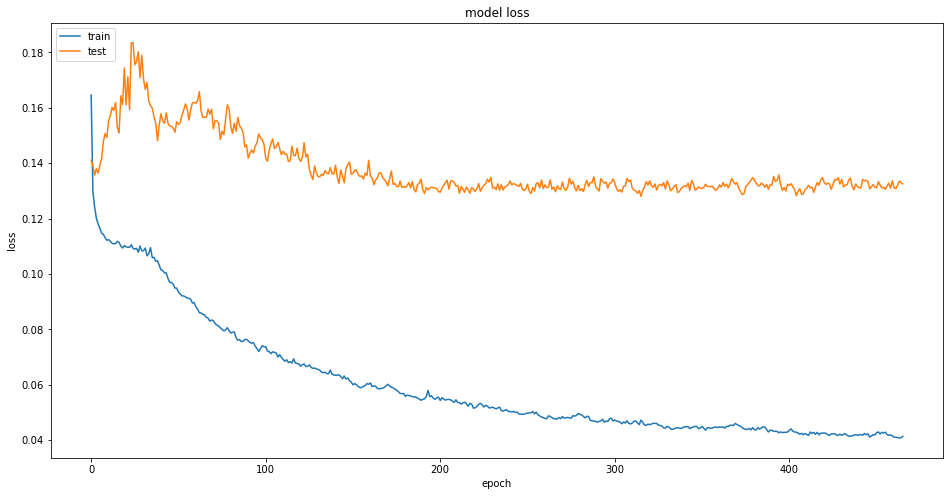

<Figure size 432x288 with 0 Axes>

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8)) 
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('EFF_Model_TrainingandValidation Loss.png')
#print(get_flops(model))

In [7]:
trainPredict = model.predict(trX, batch_size=batch_size)
validPredict = model.predict(vaX, batch_size=batch_size)
testPredict = model.predict(teX, batch_size=batch_size)
tePredict = testPredict.reshape([-1])
testY = teY.reshape([-1])

np.savetxt('Alpha0.5_EFFmodel_testPredict.txt', tePredict)
 
print(tePredict.shape)
print(testY.shape)

(109896,)
(109896,)


In [8]:
print('Error Test Score > RMSE == ', np.sqrt(np.mean(np.square(testY-tePredict))), ' MAE == ', mean_absolute_error(testY, tePredict), 'MAPE == ', mean_absolute_percentage_error(testY, tePredict))

Error Test Score > RMSE ==  0.11630393186705118  MAE ==  0.06252014191775852 MAPE ==  inf


C:\Users\Smartgrid_ML\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in true_divide


In [9]:
e_tr = trainPredict - trY
e_va = validPredict - vaY
errors = np.vstack([e_tr,e_va])
prediction = np.vstack([trainPredict,validPredict])
print(errors.shape)
print(prediction.shape)

(21453, 12)
(21453, 12)


In [10]:
norm_df = pd.DataFrame(min_max_scaler.fit_transform(df), 
                             columns=df.columns, 
                             index=df.index)
norm_df.head()

,Measured PV,Temperature C,Rainfall,Wind speed,Wind direction,Humidity,Air pressure,Dew point C,Sunshine,Solar radiation,Snowfall,Cloud cover,Surface temp C
0,0.0,0.354298,0.0,0.023256,0.000000,0.89,0.189696,0.444681,0.0,0.0,0.0,0.6,0.141834
1,0.0,0.339623,0.0,0.104651,0.444444,0.93,0.189696,0.442553,0.0,0.0,0.0,0.0,0.117479
2,0.0,0.320755,0.0,0.046512,0.388889,0.93,0.177986,0.423404,0.0,0.0,0.0,0.0,0.103152
3,0.0,0.303983,0.0,0.087209,0.444444,0.94,0.170960,0.410638,0.0,0.0,0.0,0.0,0.095989
4,0.0,0.287212,0.0,0.104651,0.444444,0.95,0.161593,0.395745,0.0,0.0,0.0,0.0,0.088825


In [11]:
norm_df2 = norm_df.iloc[:21453,[0, 1, 4, 5, 6, 8, 9, 11, 12]]
norm_df2.head()

,Measured PV,Temperature C,Wind direction,Humidity,Air pressure,Sunshine,Solar radiation,Cloud cover,Surface temp C
0,0.0,0.354298,0.000000,0.89,0.189696,0.0,0.0,0.6,0.141834
1,0.0,0.339623,0.444444,0.93,0.189696,0.0,0.0,0.0,0.117479
2,0.0,0.320755,0.388889,0.93,0.177986,0.0,0.0,0.0,0.103152
3,0.0,0.303983,0.444444,0.94,0.170960,0.0,0.0,0.0,0.095989
4,0.0,0.287212,0.444444,0.95,0.161593,0.0,0.0,0.0,0.088825


In [12]:
Prindex = ['Prediction1', 'Prediction2','Prediction3','Prediction4','Prediction5','Prediction6','Prediction7','Prediction8','Prediction9','Prediction10','Prediction11','Prediction12']
Erindex = ['Error1', 'Error2','Error3','Error4','Error5','Error6','Error7','Error8','Error9','Error10','Error11','Error12']

pr_df = pd.DataFrame(prediction, columns=Prindex)
pr_df.head()

,Prediction1,Prediction2,Prediction3,Prediction4,Prediction5,Prediction6,Prediction7,Prediction8,Prediction9,Prediction10,Prediction11,Prediction12
0,0.007701,0.004844,0.008920,0.010123,0.004724,-0.001347,-0.010758,-0.014984,0.038918,0.210248,0.426153,0.559029
1,0.012622,0.010143,0.011863,0.008886,0.004932,-0.001210,-0.012766,0.015209,0.171336,0.439043,0.637116,0.670056
2,0.009582,0.006705,0.008748,0.009074,0.004878,0.011179,0.063142,0.196377,0.394120,0.573113,0.649925,0.622287
3,0.009045,0.005351,0.007941,0.005533,-0.002178,0.037072,0.179917,0.406048,0.602080,0.654917,0.576367,0.451152
4,0.009168,0.008016,-0.001810,-0.009112,0.028025,0.164467,0.368236,0.540848,0.627720,0.627462,0.548526,0.399878


In [13]:
er_df = pd.DataFrame(errors, columns=Erindex)
er_df.head()

,Error1,Error2,Error3,Error4,Error5,Error6,Error7,Error8,Error9,Error10,Error11,Error12
0,0.007701,0.004844,0.008920,0.010123,0.004724,-0.001347,-0.010758,-0.014984,0.011011,0.052884,-0.075398,-0.033219
1,0.012622,0.010143,0.011863,0.008886,0.004932,-0.001210,-0.012766,-0.012698,0.013972,-0.062507,0.044868,-0.002812
2,0.009582,0.006705,0.008748,0.009074,0.004878,0.011179,0.035235,0.039013,-0.107430,-0.019135,-0.022943,0.033915
3,0.009045,0.005351,0.007941,0.005533,-0.002178,0.009165,0.022553,-0.095502,0.009832,-0.017951,-0.012005,-0.062026
4,0.009168,0.008016,-0.001810,-0.009112,0.000118,0.007102,-0.133314,-0.051400,-0.045148,0.039090,0.035348,0.035537


In [14]:
norm_df2 = pd.concat([norm_df2, pr_df, er_df],axis=1)
norm_df2.head()

,Measured PV,Temperature C,Wind direction,Humidity,Air pressure,Sunshine,Solar radiation,Cloud cover,Surface temp C,Prediction1,...,Error3,Error4,Error5,Error6,Error7,Error8,Error9,Error10,Error11,Error12
0,0.0,0.354298,0.000000,0.89,0.189696,0.0,0.0,0.6,0.141834,0.007701,...,0.008920,0.010123,0.004724,-0.001347,-0.010758,-0.014984,0.011011,0.052884,-0.075398,-0.033219
1,0.0,0.339623,0.444444,0.93,0.189696,0.0,0.0,0.0,0.117479,0.012622,...,0.011863,0.008886,0.004932,-0.001210,-0.012766,-0.012698,0.013972,-0.062507,0.044868,-0.002812
2,0.0,0.320755,0.388889,0.93,0.177986,0.0,0.0,0.0,0.103152,0.009582,...,0.008748,0.009074,0.004878,0.011179,0.035235,0.039013,-0.107430,-0.019135,-0.022943,0.033915
3,0.0,0.303983,0.444444,0.94,0.170960,0.0,0.0,0.0,0.095989,0.009045,...,0.007941,0.005533,-0.002178,0.009165,0.022553,-0.095502,0.009832,-0.017951,-0.012005,-0.062026
4,0.0,0.287212,0.444444,0.95,0.161593,0.0,0.0,0.0,0.088825,0.009168,...,-0.001810,-0.009112,0.000118,0.007102,-0.133314,-0.051400,-0.045148,0.039090,0.035348,0.035537


In [15]:
norm_df2 = norm_df2.iloc[:,[1,2,4,5,6,7,8,9,10,11,18,20,21,22,23,24,25,26,27,28,29,30,31,32]]

In [16]:
norm_df2 = np.array(norm_df2)
timesteps = 24
output_timesteps = 1
Xe, Ye = create_dataset(norm_df2, timesteps, output_timesteps)
print(Xe.shape)
print(Ye.shape)

(21427, 24, 24)
(21427, 1, 24)


In [17]:
trXe = Xe[:19000, :, :]
vaXe = Xe[19000:, :, :]
trYe = Ye[:19000, :, 12:]
vaYe = Ye[19000:, :, 12:]
trYe = trYe.reshape(-1,12)
vaYe = vaYe.reshape(-1,12)
print(trXe.shape)
print(trYe.shape)
print(vaXe.shape)

(19000, 24, 24)
(19000, 12)
(2427, 24, 24)


In [18]:
with tf.device('/gpu:0'):
    def make_model(hfilters, hkernel_size1):
        hkernel_size2 = 2*hkernel_size1
        num_features = 24
        alpha=1
        beta = math.sqrt(2/alpha)
        visible1e = Input(shape=(24, num_features))
        d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=1)(visible1e)
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=2)(d1)
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        res01 = Add()([d1, visible1e])   # (100, 25) (100, 25)
        d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=2)(res01)
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=4)(d1)    
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        res02 = Add()([d1, res01])   # (100, 25) (100, 25)
        d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=4)(res02) 
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=8)(d1) 
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        res03 = Add()([d1, res02])   # (100, 25) (100, 25)
        d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=8)(res03)
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=16)(d1)  
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        res04 =Add()([d1, res03])   # (100, 25) (100, 25)
        d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=16)(res04)
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=32)(d1)
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        res05 = Add()([d1, res04])   # (100, 25) (100, 25)
        d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=32)(res05) 
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=16)(d1)   
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        res06 = Add()([d1, res05])   # (100, 25) (100, 25)
        d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=16)(res06) 
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=8)(d1)
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        res07 = Add()([d1, res06])   # (100, 25) (100, 25)
        d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=8)(res07)  
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=4)(d1) 
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        res08 = Add()([d1, res07])   # (100, 25) (100, 25)
        d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=4)(res08)   
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=2)(d1)  
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        res09 = Add()([d1, res08])   # (100, 25) (100, 25)
        d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=2)(res09) 
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=1)(d1)    
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        res10 = Add()([d1, res09])   # (100, 25) (100, 25)
        oute = Conv1D(512, 1, padding='same', activation='relu')(res10)   # --------------------  
        oute = Dropout(0.2)(oute)   
        oute = Conv1D(256, 1, padding='same', activation='relu')(oute) # 1 is 1x1 conv, same is normal conv.  
        oute = Dropout(0.2)(oute)  
        oute = GlobalAveragePooling1D()(oute) # pool_size=2, strides=1
        oute = Dense(12)(oute) 
        modele = Model(inputs=[visible1e], outputs=[oute])
        modele.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', 'mape', 'accuracy'])
        return modele
    
    hfilt_cand = [128, 256, 512]
    hker_cand = [4, 8, 16]
    my_classifier = KerasClassifier(make_model, batch_size = 100)
    validator = GridSearchCV(my_classifier, param_grid = {'hfilters' : hfilt_cand, 'hkernel_size1' : hker_cand, 'epochs' : [200]})
    
    validator.fit(trXe, trYe, verbose=2)
    
    print('The parameters of the best model are: ')
    print(validator.best_params_)

Train on 15200 samples
Epoch 1/200
15200/15200 - 3s - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0286 - mean_absolute_percentage_error: 967.1473 - acc: 0.1153
Epoch 2/200
15200/15200 - 2s - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0263 - mean_absolute_percentage_error: 921.6539 - acc: 0.1258
Epoch 3/200
15200/15200 - 2s - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0251 - mean_absolute_percentage_error: 559.5260 - acc: 0.1332
Epoch 4/200
15200/15200 - 2s - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0244 - mean_absolute_percentage_error: 973.0158 - acc: 0.1570
Epoch 5/200
15200/15200 - 2s - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0236 - mean_absolute_percentage_error: 734.4837 - acc: 0.1879
Epoch 6/200
15200/15200 - 2s - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0225 - mean_absolute_percentage_error: 639.8743 - acc: 0.2289
Epoch 7/200
15200